In [8]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
import numpy as np

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

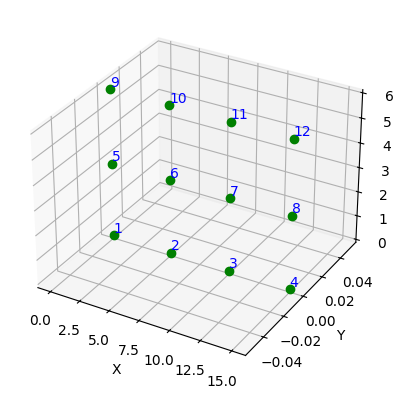

In [9]:

# Clear existing model
ops.wipe()

# Define Model Builder
ops.model('basic', '-ndm', 3, '-ndf', 6)  # 3D model with 6 DOF per node

# Define parameters
n_bay = 3        # Number of bays
l_bay = 5.0      # Length of each bay
h_bay = 3.0      # Height of each story
numStories = 2  # Number of stories

# Material properties frame
b_frame = 10
d_frame = 1
E = 200e9  # Young's Modulus in Pa
A = b_frame * d_frame   # Area of the element in m^2
EoverG = 0.001
G = E/EoverG
Iy = b_frame * d_frame**3/12
Iz = d_frame**3 * b_frame/12  # Moment of Inertia in m^4
J = Iy + Iz
beam_uniform_load = 10e3  # N/m
column_uniform_load = 20e3  # N/m

# Material properties footing
bfoot = 10
dfoot = 1
E_foot = 200e9  # Young's Modulus in Pa
A_foot = bfoot * dfoot   # Area of the element in m^2
EoverG_foot = 0.001
G_foot = E_foot/EoverG_foot
Iy_foot = bfoot * dfoot**3/12
Iz_foot = dfoot**3 * bfoot/12  # Moment of Inertia in m^4
J_foot = Iy_foot + Iz_foot

# Define footing meshing parameters
num_ele_per_footing = 4 # Needs to be even
size_per_footing = 3
ele_size_footing = size_per_footing / num_ele_per_footing
num_nodes_in_frame = (n_bay + 1) * (numStories + 1)
num_elems_in_frame = n_bay * numStories + (n_bay + 1) * numStories

# Create nodes
for i in range(numStories + 1):
    for j in range(n_bay + 1):
        nodeTag = i * (n_bay + 1) + j + 1
        x = j * l_bay
        z = i * h_bay
        ops.node(nodeTag, x, 0, z)

# Define geometric transformation
horizontal_gTTag = 1
vertical_gTTag = 2
ops.geomTransf('Linear', horizontal_gTTag, 0, 0, 1)
ops.geomTransf('Linear', vertical_gTTag, 0, 1, 0)
opsv.plot_model()


<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

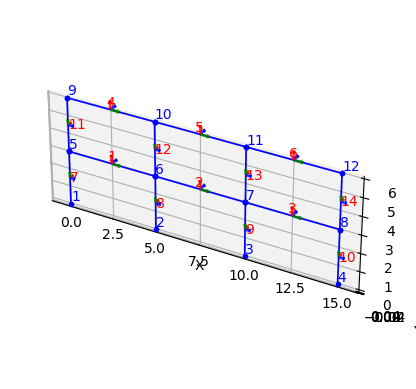

In [10]:
# Define elements
for i in range(numStories):
    for j in range(n_bay):
        # Horizontal elements (beams)
        nodeI = (i + 1) * (n_bay + 1) + j + 1
        nodeJ = nodeI + 1
        eleTag = i * (n_bay) + j + 1
        ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A, E, G, J, Iy, Iz, horizontal_gTTag)

    for j in range(n_bay + 1):
        if i < numStories:
            # Vertical elements (columns)
            nodeI = i * (n_bay + 1) + j + 1
            nodeJ = nodeI + (n_bay + 1)
            eleTag = n_bay * numStories + i * (n_bay + 1) + j + 1
            ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A, E, G, J, Iy, Iz, vertical_gTTag)
opsv.plot_model()
# sfac = opsv.plot_defo()

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

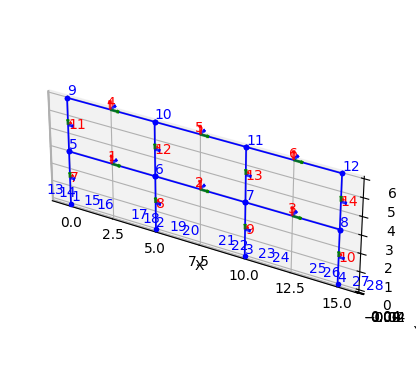

In [11]:
# Define footing nodes
num_ele_per_footing = 4 # Needs to be even
size_per_footing = 3
ele_size_footing = size_per_footing / num_ele_per_footing
num_nodes_in_frame = (n_bay + 1) * (numStories + 1)
num_elems_in_frame = n_bay * numStories + (n_bay + 1) * numStories
# Define nodes for footing
for i in range(n_bay + 1):
    x_footing_center = i * l_bay
    x_footing_start = x_footing_center - size_per_footing / 2
    for j in range(num_ele_per_footing + 1):
        if j == num_ele_per_footing / 2:
            continue
        if j < num_ele_per_footing / 2:
            nodeTag = num_nodes_in_frame + i * num_ele_per_footing + j + 1
        else:
            nodeTag = num_nodes_in_frame + i * num_ele_per_footing + j
        x = x_footing_start + j * ele_size_footing
        z = 0
        ops.node(nodeTag, x, 0, z)
        
opsv.plot_model()    
        

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

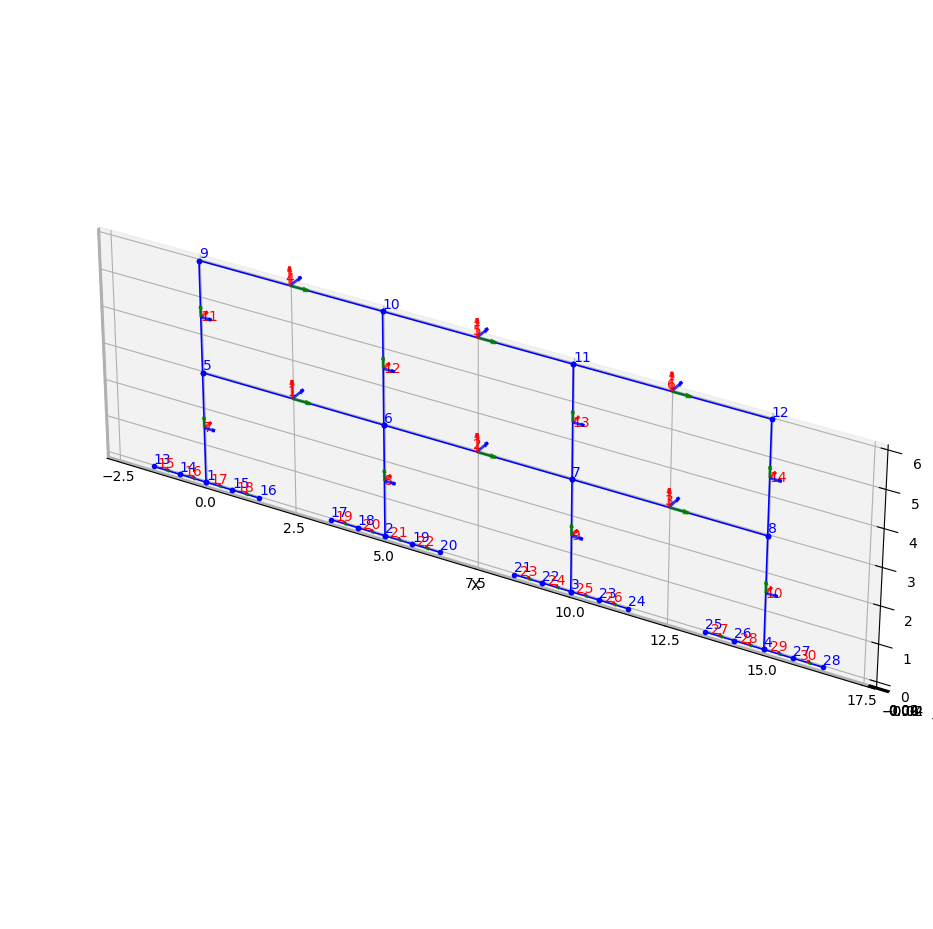

In [12]:
# Define elements for footing   
for i in range(n_bay + 1):
    for j in range(num_ele_per_footing):
        if j < num_ele_per_footing / 2 - 1:
            nodeI = num_nodes_in_frame + i * num_ele_per_footing + j + 1
            nodeJ = nodeI + 1
        elif j == num_ele_per_footing / 2 - 1:
            nodeI = num_nodes_in_frame + i * num_ele_per_footing + j + 1
            nodeJ = i + 1
        elif j == num_ele_per_footing / 2:
            nodeI = i + 1
            nodeJ = num_nodes_in_frame + i * num_ele_per_footing + j + 1
        else:
            nodeI = num_nodes_in_frame + i * num_ele_per_footing + j
            nodeJ = nodeI + 1
        eleTag = num_elems_in_frame + i * num_ele_per_footing + j + 1
        ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_foot, E_foot, G_foot, J_foot, Iy_foot, Iz_foot, horizontal_gTTag)
# plt.figure(figsize=(20, 8))  # Set the plot size (width, height)
opsv.plot_model(fig_wi_he = (50,30))
# plt.show()

In [13]:
# Define self weight
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)

beam_elem_tags = list(range(1, n_bay * numStories + 1))
ops.eleLoad('-ele', *beam_elem_tags, '-type', '-beamUniform', 0, beam_uniform_load,0)

In [14]:
# Analysis
ops.system("FullGeneral")
ops.numberer("Plain")
ops.constraints("Plain")
ops.integrator("LoadControl", 1)
ops.algorithm("Linear")
ops.analysis("Static")
analysis_result = ops.analyze(1)

In [15]:
# get the stiffness matrix
N = ops.systemSize()
K = ops.printA('-ret')
K = np.array(K).reshape((N, N))

In [16]:
ops.printB('-ret')

[-15729.003482394746,
 0.0,
 -6622.73830837672,
 0.0,
 23593.505223592132,
 0.0,
 3311.3691541883745,
 0.0,
 -34769.37611897786,
 0.0,
 22765.66293504503,
 0.0,
 -12003.713183932836,
 0.0,
 26490.953233506938,
 0.0,
 -3311.3691541883654,
 0.0,
 413.92114427356137,
 0.0,
 99341.07462565094,
 0.0,
 67469.14651658805,
 0.0,
 -3394.153383043071,
 0.0,
 -1673.0785369873047,
 0.0,
 1270.0557708739943,
 0.0,
 -910.626517401819,
 0.0,
 -1607.6882680257186,
 0.0,
 5877.680248684366,
 0.0,
 -14156.103134155273,
 0.0,
 3061.342239379883,
 0.0,
 -1241.7634328206477,
 0.0,
 -3476.9376118977816,
 0.0,
 -13693.348566691071,
 0.0,
 1710.1764678955078,
 0.0,
 -6705.522537231445,
 0.0,
 -21938.657760620117,
 0.0,
 2760.171890258789,
 0.0,
 13493.829303317616,
 0.0,
 -167.24268595377362,
 0.0,
 -496.70537312827946,
 0.0,
 -662.273830837672,
 0.0,
 11008.628209431958,
 0.0,
 1158.9792039659224,
 0.0,
 -4884.2695024278655,
 0.0,
 22019.76776123047,
 0.0,
 3200.2925872803025,
 0.0,
 0.0,
 0.0,
 79472.859700

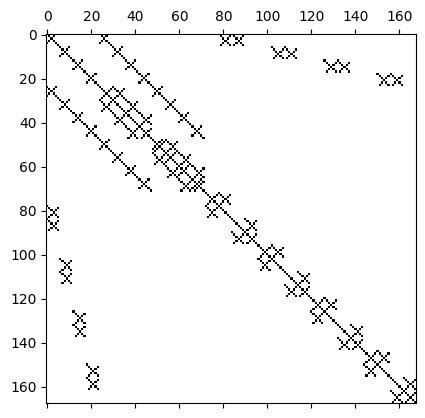

In [61]:
plt.spy(K)

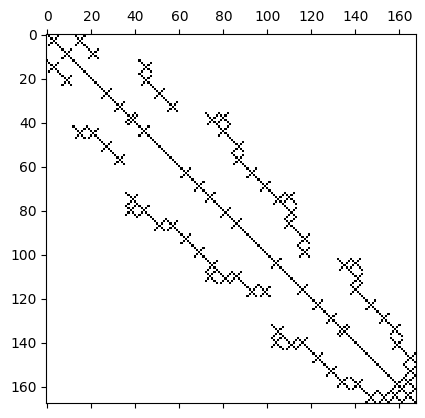

In [47]:
plt.spy(K)

In [ ]:
# Give the ops object to ASRE_2D_frame_model()
# Give the z_foot, x_foot, y_foot, es, nnode, h_el_foot, nis, bfoot to ASRE_2D_frame_model()


WARNING FullGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 362
WARNING NewtonRaphson::solveCurrentStep() -the LinearSysOfEqn failed in solve()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.1
OpenSees > analyze failed, returned: -3 error flag


IndexError: index 0 is out of bounds for axis 1 with size 0

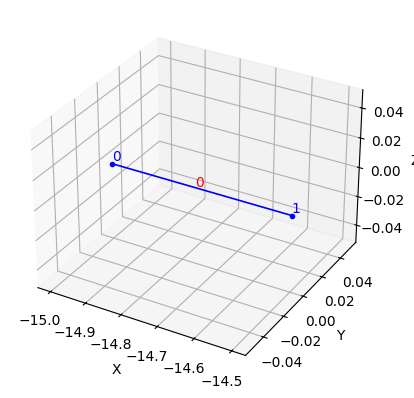

In [83]:
import numpy as np
# Import OpenSeesPy
from openseespy.opensees import *

# Wipe existing model
ops.wipe()

# Define the model builder
ops.model('basic', '-ndm', 3, '-ndf', 6)  # 3D model with 6 DOF per node

# Define nodes
beamX = np.linspace(-15, 15, 61)
nodeTag = 0
for i, x in enumerate(beamX):
    ops.node(i, x, 0.0, 0.0)

# Define boundary conditions
# fix(1, 1, 1, 1)
# fix(3, 1, 1, 0)

# Material properties
bfoot = 10
dfoot = 0.12
E = 70e9  # Young's Modulus in Pa
A = bfoot * dfoot   # Area of the element in m^2
EoverG = 2.6
G = E/EoverG
Iy = dfoot**3 * bfoot/12
Iz = bfoot**3 * dfoot/12  # Moment of Inertia in m^4
J = Iy + Iz

# Define coord transfer
horizontal_gTTag = 1
vertical_gTTag = 2
ops.geomTransf('Linear', horizontal_gTTag, 0, 0, 1)

# Define elements
for i in range(beamX.size - 1):
    # ops.element('elasticBeamColumn', i, i, i+1, A, E, G, J, Iy, Iz, horizontal_gTTag)
    ops.element('ElasticTimoshenkoBeam', i, i, i+1, E, G, A, J, Iy, Iz, bfoot*dfoot, bfoot*dfoot,horizontal_gTTag)

# Define constraints and analysis
ops.constraints('Plain')
ops.numberer('RCM')
ops.system('FullGeneral')
ops.test('NormDispIncr', 1.0e-6, 10)
ops.algorithm('Newton')
ops.integrator('LoadControl', 0.1)
ops.analysis('Static')

# Perform the analysis
ops.analyze(1)

# Print the global stiffness matrix
# ops.printA()

# Optional: Print the stiffness matrix to a file

K = ops.printA('-ret')
opsv.plot_model()

In [ ]:
N = ops.systemSize() # Has to be done after analyze
K = np.array(K)
K.shape = (N,N)
print(K)

[[1.68000000e+11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.45533141e+10 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.41636515e+09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.38539077e+11
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.27622822e+08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.40403458e+12]]


In [ ]:
np.savetxt('opensees_K.txt', K, fmt = '%.4e')

In [ ]:
L = beamX[1] - beamX[0]
print(12*E*Iz/L**3 * 1e-13)
print(G*J/L)

6.720000000000001
538539076923.07697
